# 说明：

（1）Keras支持RNN网络的各种变体，且都是以“层”的形式使用：
- layers.LSTM
- layers.GRU

（2）输入的是：一个三维数据；可分下面两种情况：
- 评论数据：（批次，一段话包含的单词总数，每个单词转换为词嵌入表示的向量长度）
- 天气预测： (批次，需要使用前面的多少天，每天当中的各个影响特征(如风向、含水量、云密度值等) )

（3）什么任务会用RNN网络：
- 文本评价问题：数据是一段话，判断这一段话是褒是贬；这句话总体的态度，肯定“从头读到尾”逐渐“**综合**”判断出来的（因为有些人会欲扬先抑、欲抑先扬等说话方式）。即：一句话整体的态度，是前后内容综合联系判断的结果。
- 序列数据问题：数据还是像回归问题那种“多特征”的数据，但是这些“特征 + 结果”前面的数据会影响后面的结果！此时再只用普通的回归就学不会前面数据的对后面数据影响的这点。

综上：RNN网络处理有“**前面对后面有影响**”的数据(文本评论)或结果(序列数据)。—— 至于到底是“前面多少个”对后面有影响，LSTM会自己处理。

# 数据预处理：和前面36一样

In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
data = keras.datasets.imdb

In [3]:
max_word = 10000  # 考虑前10000个最常用的单词
# x是数据，y是标签
(x_train, y_train), (x_test, y_test) = data.load_data(num_words = max_word)

### 词嵌入处理： 

In [4]:
# 把长度不同的评论(训练+测试)，填充为长度相同：
maxlen = 200  # 填充的最大长度
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

x_train.shape, x_test.shape   # 每一句话，又转为一个长度为200的一维数组里

((25000, 200), (25000, 200))

# 模型搭建：

In [5]:
model = keras.Sequential()

In [6]:
from keras import layers

In [7]:
model.add( layers.Embedding(10000, 20, input_length=maxlen) )  # 词嵌入表示

In [8]:
# 查看一下这一层的输入是什么形状、输出是什么形状：
model.input_shape, model.output_shape

((None, 200), (None, 200, 20))

### 加入LSTM网络：

In [10]:
# LSTM一般只用自定“神经元数”即可，其他用默认的就很好！
model.add( layers.LSTM(128) )

In [11]:
# 查看一下该层的输出：一个二维的(批次，结果) —— 结果就是对那“一段话中所有单词综合循环分析”后得出的“一个结论”
# 128个神经元，就是128个结论；所以输出是（批次，128）
model.output_shape

(None, 128)

### 加入全连接层：仍是起“特征汇总”的作用

In [12]:
model.add( layers.Dense(64, activation='relu') )
model.add( layers.Dense(1, activation='sigmoid') )   #  二分类 

In [13]:
model.compile( optimizer = 'adam',
               loss = 'binary_crossentropy',
               metrics = ['acc']  # 因为metrics里面可以算很多东西，所以用列表
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
history = model.fit( x_train, y_train, epochs = 5, batch_size = 256, validation_data = (x_test, y_test) )


Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 66s 3ms/step - loss: 0.6162 - acc: 0.6905 - val_loss: 0.4237 - val_acc: 0.8097
Epoch 2/5
25000/25000 [==============================] - 66s 3ms/step - loss: 0.3109 - acc: 0.8712 - val_loss: 0.3142 - val_acc: 0.8666
Epoch 3/5
25000/25000 [==============================] - 65s 3ms/step - loss: 0.2052 - acc: 0.9217 - val_loss: 0.3091 - val_acc: 0.8696
Epoch 4/5
25000/25000 [==============================] - 66s 3ms/step - loss: 0.1682 - acc: 0.9405 - val_loss: 0.3244 - val_acc: 0.8670
Epoch 5/5
25000/25000 [==============================] - 66s 3ms/step - loss: 0.1372 - acc: 0.9518 - val_loss: 0.4046 - val_acc: 0.8578


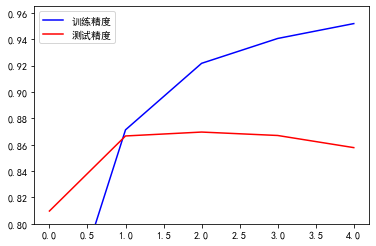

In [15]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False    # 步骤二（解决坐标轴负数的负号显示问题）
# 训练精度与测试精度的对比图：
plt.plot( history.epoch, history.history.get('acc'), c = 'b', label = '训练精度' )
plt.plot( history.epoch, history.history.get('val_acc'), c = 'r', label = '测试精度' )
plt.ylim( ymin=0.8 )
plt.legend()